# Tree object detection using airborne images and LiDAR point clouds

Alexandre Bry ([École polytechnique](https://portail.polytechnique.edu/informatique/fr/page-daccueil), [Geodan B.V.](https://research.geodan.nl/))  
July 22, 2024

This is the abstract. It can be on multiple lines and contain **Markdown**.

## Introduction

The goal of the internship was to study the possibility of combining LiDAR point clouds and aerial images in a deep learning model to identify individual trees. The two types of data are indeed complementary, as point clouds capture geometric shapes, while images capture colors. However, combining them into a format that allows a model to handle them simultaneously is not a straightforward task because they inherently have a very different spatial repartition and encoding.

In this work, I focused on one specific deep learning model, and tried to improve it by using more information from the LiDAR point cloud. To do this, I had to create my own tree annotations dataset, with which I also tried to study the ability of this new model to detect trees that are covered by other trees.

## State-of-the-art

### Computer vision tasks related to trees

Before talking about models and datasets, let’s define properly the task that this project focused on, in the midst of all the various computer vision tasks, and specifically those related to tree detection.

The first main differentiation between tree recognition tasks comes from the acquisition of the data. There are some very different tasks and methods using either ground data or aerial/satellite data. This is especially true when focusing on urban trees, since a lot of street view data is available \[@urban-trees\].

This leads to the second variation, which is related to the kind of environment that we are interested in. There are mainly three types of environments, which among other things, influence the organization of the trees in space: urban areas, tree plantations and forests. This is important, because the tasks and the difficulty depends on the type of environment. Tree plantations are much easier to work with than completely wild forests, while urban areas contain various levels of difficulty ranging from alignment trees to private and disorganized gardens and parks. For this project, we mainly focused on urban areas, but everything should still be applicable to tree plantations and forests.

Then, the four fundamental computer vision tasks have their application when dealing with trees \[@olive-tree\]:

-   Classification, although this is quite rare for airborne tree applications since there are multiple trees on each image most of the time
-   Detection, which consists in detecting objects and placing boxes around them
-   Semantic segmentation, which consists in associating a label to every pixel of an image
-   Instance segmentation, which consists in adding a layer of complexity to semantic segmentation by also differentiating between the different instances of each class

These generic tasks can be extended by trying to get more information about the trees. The most common information are the species and the height, but some models also try to predict the health of the trees, or their carbon stock.

In this work, the task that is tackled is the detection of trees, with a special classification between several labels related to the discrepancies between the different kinds of data. The kind of model that is used would also have allowed to focus on some more advanced tasks, by replacing detection with instance segmentation and asking the model to also predict the species. But due to the difficulties regarding the dataset, a simpler task with a simpler dataset was used, without compromising the ability to experiment with different possible improvements of the model. The difficulties and the experiments are developed below.

### Datasets

#### Requirements

Before presenting the different promising datasets and the reasons why they were not fully usable for the project, let’s enumerate the different conditions and requirements for the tree instance segmentation task:

-   Multiple types of data:
    -   Aerial RGB images
    -   LiDAR point clouds (preferably aerial)
    -   (Optional) Aerial infrared (CIR) images
-   Tree crown annotations or bounding boxes
-   High-enough resolution:
    -   For images, about 25 cm
    -   For point clouds, about 10 cm

Here are the explanations for these requirements. As for the types of data, RGB images and point clouds are required to experiment on the ability of the model to combine the two very different kinds of information they hold. Having infrared data as well could be beneficial, but it was not necessary. Regarding tree annotations, it was necessary to have a way to spatially identify them individually, using crown contours or simply bounding boxes. Since the model outputs bounding boxes, any kind of other format could easily be transformed to bounding boxes. Finally, the resolution had to be high enough to identify individual trees and be able to really use the data. For the point clouds especially, the whole idea was to see if and how the topology of the trees could be learnt, using at least the trunks and even the biggest branches if possible. Therefore, even if they are not really comparable, this is the reason why the required resolution is more precise for the point clouds.

Unfortunately, none of the datasets that I found matched all these criteria. Furthermore, I didn’t find any overlapping datasets that I could merge to create a dataset with all the required types of data. In the next parts, I will go through the different kinds of datasets that exist, the reasons why they did not really fit for the project and the ideas I got when searching for a way to use them.

#### Existing tree datasets

As explained above, there were quite a lot of requirements to fulfill to have a complete dataset usable for the task. This means that almost all the available datasets were missing something, as they were mainly focusing on using one kind of data and trying to make the most out of it, instead of trying to use all the types of data together.

The most comprehensive list of tree annotations datasets was published in OpenForest \[@OpenForest\]. FoMo-Bench \[@FoMo-Bench\] also lists several interesting datasets, even though most of them can also be found in OpenForest. Without enumerating all of them, there were multiple kinds of datasets that all have their own flaws regarding the requirements I was looking for.

Firstly, there are the forest inventories. TALLO \[@TALLO\] is probably the most interesting one in this category, because it contains a lot of spatial information about almost 500K trees, with their locations, their crown radii and their heights. Therefore, everything needed to localize trees is in the dataset. However, I didn’t manage to find RGB images or LiDAR point clouds of the areas where the trees are located, making it impossible to use these annotations to train tree detection.

Secondly, there are the RGB datasets. ReforesTree \[@ReforesTree\] and MillionTrees \[@MillionTrees\] are two of them and the quality of their images are high. The only drawback of these datasets is obviously that they don’t provide any kind of point cloud, which make them unsuitable for the task.

Thirdly, there are the LiDAR datasets, such as \[@WildForest3D\] and \[@FOR-instance\]. Similarly to RGB datasets, they lack one of the data source for the task I worked on. But unlike them, they have the advantage that the missing data could be much easier to acquire from another source, since RGB aerial or satellite images are much more common than LiDAR point clouds. However, this solution was abandoned for two main reasons. First it is quite challenging to find the exact locations where the point clouds were acquired. Then, even when the location is known, it is often in the middle of a forest where the quality of satellite imagery is very low.

Finally, I also found two datasets that had RGB and LiDAR components. The first one is MDAS \[@MDAS\]. This benchmark dataset encompasses RGB images, hyperspectral images and Digital Surface Models (DSM). There were however two major flaws. The obvious one was that this dataset was created with land semantic segmentation tasks in mind, so there was no tree annotations. The less obvious one was that a DSM is not a point cloud, even though it is some kind of 3D information and was often created using a LiDAR point cloud. As a consequence, I would have been very limited in my ability to use the point cloud.

The only real dataset with RGB and LiDAR came from NEON \[@NEONdata\]. This dataset contains exactly all the data I was looking for, with RGB images, hyperspectral images and LiDAR point clouds. With 30975 tree annotations, it is also a quite large dataset, spanning across multiple various forests. The reason why I decided not to use it despite all this is that at the beginning of the project, I thought that the quality of the images and the point clouds was too low. Looking back on this decision, I think that I probably could have worked with this dataset and gotten great results. This would have saved me the time spent annotating the trees for my own dataset, which I will talk more about later. My decision was also influenced by the quality of the images and the point clouds available in the Netherlands, which I will talk about in the next section.

#### Public data

After rejecting all the available datasets I had found, the only solution I had left was to create my own dataset. I won’t dive too much in this process that I will explain in @sec-dataset. I just want to mention all the publicly available datasets that I used or could have used to create this custom dataset.

For practical reasons, the two countries where I mostly searched for available data are France and the Netherlands. I was looking for three different data types independently:

-   RGB (and if possible CIR) images
-   LiDAR point clouds
-   Tree annotations

These three types of data are available in similar ways in both countries, although the Netherlands have a small edge over France. RGB images are really easy to find in France with the BD ORTHO \[@IGN_BD_ORTHO\] and in the Netherlands with the Luchtfotos \[@Luchtfotos\], but the resolution is better in the Netherlands (8 cm vs 20 cm). Hyperspectral images are also available in both countries, although for those the resolution is only 25 cm in the Netherlands.

As for LiDAR point clouds, the Netherlands have a small edge over France, because they have already completed their forth version covering the whole country with AHN4 \[@AHN4\], and are working on the fifth version. In France, data acquisition for the first LiDAR point cloud covering the whole country started a few years ago \[@IGN_LiDAR_HD\]. It is not yet finished, even though data is already available for half of the country. The other advantage of the data from Netherlands regarding LiDAR point clouds is that all flights are performed during winter, which allows light beams to penetrate more deeply in trees and reach trunks and branches. This is not the case in France.

The part that is missing in both countries is related to tree annotations. Many municipalities have datasets containing information about all the public trees they handle. This is for example the case for Amsterdam \[@amsterdam_trees\] and Bordeaux \[@bordeaux_trees\]. However, these datasets cannot really be used as ground truth for a custom dataset for several reasons. First, many of them do not contain coordinates indicating the position of each tree in the city. Then, even those that contain coordinates are most of the time missing any kind of information allowing to deduce a bounding box for the tree crowns. Finally, even if they did contain everything, they only focus on public trees, and are missing every single tree located in a private area. Since public and private areas are obviously imbricated in all cities, it means that any area we try to train the model on would be missing all the private trees, making the training process impossible because we cannot have only a partial annotation of images.

The other tree annotation source that we could have used is Boomregister \[@boomregister\]. This work covers the whole of the Netherlands, including public and private trees. However, the precision of the masks is far from perfect, and many trees are missing or incorrectly segmented, especially when they are less than 9 m heigh or have a crown diameter smaller than 4 m. Therefore, even it is a very impressive piece of work, we thought that it could not be used as training data for a deep learning models due to its biases and imperfections.

#### Dataset augmentation techniques

When a dataset is too small to train a model, there are several ways of artificially enlarging it.

The most common way to do it is to randomly apply deterministic or random transformations to the data, during the training process, to be able to generate several unique and different realistic data instances from one real data instance. There are a lot of different transformations that can be applied to images, divided into two categories: pixel-level and spatial-level \[@albumentations\]. Pixel-level transformations modify the value of individual pixels, by applying different filters, such as random noise, color shifts and more complex effects like fog and sun flare. Spatial-level transformations modify the spatial arrangement of the image, without changing the pixel values. In other words, these transformations move the pixels in the image. The transformations range from simple rotations and croppings to complex spatial distortions. In the end, all these transformations are simply producing one artificial image out of one real image.

Another way to enlarge a dataset is to instead generate completely new input data sharing the same properties as the initial dataset. This can be done using Generative Adversarial Networks (GAN). These models usually have two parts, a generator and a discriminator, which are trained in parallel. The generator learns to produce realistic artificial data, while the discriminator learns to identify real data and artificial data produced by the generator. If the training is successful, we can then use the generator and random seeds to generate random but realistic artificial data similar to the dataset. This method has for example been successfully used to generate artificial tree height maps \[@gan_data_augment\].

### Algorithms and models

In this section, the different algorithms and methods are grouped according to the type of data they use as input.

#### Images only

Then, there are methods that perform tree detection using only visible or hyperspectral images or both. Several different algorithms have been developed to analytically delineate tree crowns from RGB images, by using the particular shape of the trees and its effect on images \[@rgb_analytical\]. Without diving into the details, here are a few of them. The watershed algorithm identifies trees to inverted watersheds in the grey-scale image and tree crowns frontiers are found by incrementally flooding the watersheds \[@watershed\]. The local maxima filtering uses the intensity of the pixels in the grey-scale image to identify the brightest points locally and use them as treetops \[@local-maximum\]. Reversely, the valley-following algorithm uses the darkest pixels which are considered as the junctions between the trees since shaded areas are the lower part of the tree crowns \[@valley-following\]. Another interesting algorithm is template matching. This algorithm simulates the appearance of simple tree templates with the light effects, and tries to identify similar patterns in the grey-scale image \[@template-matching\]. Combinations of these techniques and others have also been proposed.

But with the recent developments of deep learning in image analysis, deep learning models are increasingly used to detect trees using RGB images. In some cases, deep learning is used to extract features that can then be the input of one of the algorithms described above. One example is the use of two neural networks to predict masks, outlines and distance transforms which can then be the input of a watershed algorithm \[@rgb-dl-watershed\]. In other cases, a deep learning model is responsible of directly detecting tree masks or bounding boxes, often using CNNs, given the images \[@DeepForest\].

#### LiDAR only

Some of the methods to identify individual trees use LiDAR data only. There are a lot of different ways to use and analyze point clouds, but the one that is mostly used for trees is based on height maps, or Canopy Height Models (CHM).

A CHM is a raster computed as the subtraction of the Digital Terrain Model (DTM) to the Digital Surface Model (DSM). What it means is that a CHM contains the height above ground of the highest point in the area corresponding to each pixel. This CHM can for example be used as the input raster for the watershed algorithm, as it contains the height values that can be used to determine local maxima \[@lidar_watershed\]. A lot of different analytical methods and variations of the simple CHM were proposed to perform individual tree detection, but in the end, most of them still the concept of local maxima \[@lidar_benchmark; @lidar_benchmark_2\]. A CHM can also be used as the input of any kind of convolutional neural network (CNN) because it is shaped exactly like any image. This allows to use a lot of different techniques usually applied to object detection in images.

Then, even though I finally used an approach similar to the CHM, I want to mention other kinds of deep learning techniques that exist and could potentially leverage all the information contained in a point cloud. These techniques can be divided in two categories: projection-based and point-based methods \[@lidar_classification\]. The main difference between the two is that projection-based techniques are based on grids while point-based methods take unstructured point clouds as input. Among projection-based methods, the most basic method is 2D CNN, which is how CHM can be processed. Then, multiview representation tries to tackle the 3D aspect by projecting the point cloud in multiple directions before merging them together. To really deal with 3D data, volumetric grid representation consists in using 3D occupancy grids, which are processed using 3D CNNs. Among point-based methods, there are methods based on PointNet, which are able to extract features and perform the classical computer vision tasks by taking point clouds as input. Finally, Convolutional Point Networks use a continuous generalization of convolutions to apply convolution kernels to arbitrarily distributed point clouds.

#### LiDAR and images

Let’s now talk about the models of interest for this work, which are machine learning pipelines using both LiDAR point cloud data and RGB images.

The first pipeline \[@lidar_rgb_wst\] uses a watershed algorithm to extract crown boundaries, before extracting individual tree features from the LiDAR point cloud, hyperspectral and RGB images. These features are then used by a random forest classifier to identify which species the tree belongs to. This pipeline therefore makes the most out of all data to identify species, but sticks to an improved variant of the watershed for individual tree segmentation, which only uses a CHM raster.

Other works focused on using only one model that is able to take both the CHM and the RGB data as input and combine them to make the most out of all the available data. Among other models, there are for example ACE R-CNN \[@lidar_rgb_acnet\], an evolution of Mask region-based convolution neural network (Mask R-CNN) and AMF GD YOLOv8 \[@amf_gd_yolov8\], an evolution of YOLOv8. These two models have proven to give much better results when using both the images and the LiDAR data as a CHM thant when using only one of them.

## Objectives and motivations

In this section, I will explain the objectives that I set for this internship and the motivations that led to them.

### Data and model

The basis for this internship was to look at deep learning models to detect trees using LiDAR and aerial images. In fourth months, it would have been difficult to dive into the literature, think about a completely new approach and develop it. Therefore, I wanted to find an interesting and not too complicated deep learning model, and try a few changes that would hopefully improve the results.

This idea was also reinforced by the decision to create my own dataset for two reasons. The first reason was the small number of openly available tree annotation datasets which contained both LiDAR and RGB data. I therefore thought that creating a new dataset and making it available could be a great contribution. The second reason was to have more control over the definition and the characteristics of the dataset, to be able to experiment on the detection of specific trees.

### Covered trees

The main thing that I wanted to experiment on was the possibility to make a better use of the LiDAR point cloud to be able to detect covered trees. Covered trees are the trees which are located partially or completely under another tree’s crown. This makes them impossible to completely delineate when using only data that is visible from above. These trees are not meaningless or negligible, because as demonstrated in this paper \[@lidar_benchmark_2\], they can represent up to 50% of the trees in a forest.

However, doing this implied being able to process them on the whole pipeline. In practice, covered trees are never annotated in all the datasets that are created using only RGB images, because they are simply not visible. This means that creating my own dataset was the only solution to have a dataset containing really all trees including covered trees and be able to easily identify them.

### Multiple layers of CHM

Being able to find covered trees meant finding a way to find more information out of the LiDAR point cloud than what is contained by the CHM. In fact, the CHM only contains a very small part of the point cloud and doesn’t really benefit from the 3D shape that is contained in the point cloud. This is particularly true when the point cloud is acquired in a season where trees don’t have their leaves, because the LiDAR then goes deep into the tree more easily, and can find the trunk and many of the largest branches.

Therefore, getting information below the tree crown surface was mandatory to find covered trees. But it could also be helpful for the model to find better separations between each tree, thanks to having access to the branches and the trunks. Even though I didn’t end up asking the model to also identify the species, this is another task that could have been improved a lot if the model could use the architecture of the branches.

To do this, I wanted to stick with a simple solution that would integrate well with the initial model and wouldn’t require too many changes. The idea I implemented is therefore very simple. Instead of having only one CHM raster, I would have multiple layers, each focusing on a different height interval. There are many ways to do this, but due to a lack of time, I only really tried what seemed to me the easiest and most straightforward way to do it, which consists in removing all the points above a certain height threshold, and compute the CHM with the points that are left. When doing this for multiple height thresholds, we get an interesting view of what the point cloud looks like at multiple levels, which gives a lot more information about the organization of the point cloud. Another way to do this, which is used in the third method of this paper \[@lidar_benchmark\], would be instead to use the previous CHM by removing all the points that are in the interval between the CHM height and 0.5 m below, before computing an additional layer. It could be interesting to see if this method works better than dropping the points at pre-determined heights.

## Dataset creation

The highest resolution of the CHM which keeps a high enough quality depends entirely on the density of the point cloud. Also, depending on the season when the point cloud is acquired, using a CHM might imply throwing away the majority of the information contained in the point cloud.

### Definition and content

As explained in the section \[@sec-sota-datasets-requirements\], the main requirements of the dataset that I wanted to create were to contain at the same time LiDAR data, RGB data and CIR data, with simple bounding box annotations for all trees. And as explained in \[@sec-obj-covered_trees\], all trees means also annotating trees that are partially or completely covered by other trees.

Then, to make the most out of the point cloud resolution and the RGB images resolution, I decided to use a CHM resolution of 8 cm, which is also the resolution of the RGB images. However, the resolution of CIR images is 25 cm, which made it less optimal, but still usable.

To be able to get results even with a small dataset, I decided to focus on one specific area, to limit the diversity of trees and environments to something that could hopefully still be learnt with a small dataset. Therefore, the whole dataset is currently inside of a 1 km × 1 km square around Geodan office, in Amsterdam. It contains 2726 annotated trees spread over 241 images of size 640 px × 640 px i.e. 51.2 m × 51.2 m. All tree annotations have at least a bounding box, and some of them have a more accurate polygon representing the shape of the crown. There are four classes, which I will detail in the next section \[@sec-dataset-challenges\], and each tree belongs to one class.

Annotating all these trees took me about 100 hours, with a very high variation of the time spent on each tree depending on the complexity of the area.

### Challenges and solutions

The creation of this dataset raised a number of challenges. The first one was the interval of time between the acquisition of the different types of data. While the point cloud data dated from 2020, the RGB images were acquired in 2023. It would have been possible to use images from 2021 or 2022 with the same resolution, but the quality of the 2023 images was much better. Consequently, there were a certain amount of changes regarding trees between these two periods of acquisition. Some large trees were cut off, while small trees were planted, sometimes even at the position of old trees that were previously cut off in the same time frame. For this reason, a non negligible number of trees were either present only in the point cloud, or only in the images. To try to handle this situation, I created two new class labels corresponding to these situation. This amounted up to 4 class labels:

-   “Tree”: trees which are visible in the point cloud and the images
-   “Tree_LiDAR”: trees which are visible in the point cloud only but would be visible in the images if they had been there during the acquisition
-   “Tree_RGB”: trees which are visible in the images only but would be visible in the point cloud if they had been there during the acquisition
-   “Tree_covered”: trees that are visible in the point cloud only because they are covered by other trees.

All these labels theoretically correspond to situations that have no intersection, even though it is more complicated in practice.

The next challenge was the misalignment of images and point cloud. This misalignment comes from the images not being perfectly orthonormal. Point clouds don’t have this problem, because the data is acquired and represented in 3D, but images have to be projected to a 2D plane after being acquired with an angle that is not perfectly orthogonal to the plane. Despite the post-processing that was surely performed on the images, they are therefore not perfect, and there is a shift between the positions of each object in the point cloud and in the images. This shift cannot really be solved, because it depends on the position. Because of this misalignment, a choice had to be made as to where tree annotations should be placed, using either the point clouds or the RGB images. I chose to the RGB images as it is simpler to visualize and annotate, but there was not really a perfect choice.

Finally, the last challenge comes from the definition of what we consider as a tree and what we don’t. There are two main sub-problems. The first one comes from the threshold to set between bushes and trees. Large bushes can be much larger than small trees, and sometimes have a similar shape. Therefore, it is hard to keep coherent rules when annotating them. The second sub-problem comes from multi-stemmed and close trees. It can be very difficult to see, even with the point cloud, if a there is only one tree with two or more trunks dividing at the bottom, or multiple trees which are simply close to one another. (Un)fortunately I know that I was not the only one to face this problem because it was also mentioned in another paper \[@DeepForestBefore\]. In the end, it was just an unsolvable problem for which the most important was to remain consistent in the whole dataset.

### Augmentation methods

Dataset augmentation methods are in the middle between dataset creation and deep learning model training, because they are a way to enhance the dataset but depend on the objective for which the model is trained. Their importance is inversely proportional with the size of the dataset, which made them very important for my small dataset.

As it was already explained in \[@sec-sota-dataset-augment\], I used Albumentations \[@albumentations\] to apply two types of augmentations: pixel-level and spatial-level.

Spatial-level augmentations had to be in the exact same way to the whole dataset, to maintain the spatial coherence between RGB images, CIR images and the CHM layers. I used three different spatial transformations, applied with random parameters. The first one chooses one of the eight possible images we can get when flipping and rotating the image by angles that are multiples of 90°. The second one adds a perspective effect to the images. The third one adds a small distortion to the image.

On the contrary, Pixel-level augmentations must be applied differently to RGB images and CHM layers because they represent different kinds of data, so the values of the pixels do not have the same meaning. In practice, a lot of transformations were conceived to reproduce camera effects on RGB images or to shift the color spectrum. Among others, I used random modifications of the brightness, the gamma value and added noise and a blurring effect randomly to RGB images. For both types of data, a channel dropout is also randomly applied, leaving a random number of channels and removing the others. A better way to augment the CHM data would have been to apply random displacements and deletions of points in the point cloud, before computing the CHM layers. However, these operations are too costly to be integrated in the training pipeline without consequently increasing the training time, so this idea was discarded.

## Model and training

The deep learning model that is used is based on AMF GD YOLOv8, the model proposed in this paper \[@amf_gd_yolov8\].

### Model architecture

The architecture of the model is conceptually simple. The model takes two inputs in the form of two rasters with the same height and width. The two inputs are processed using the backbone of the YOLOv8 model \[@yolo\] to extract features at different scales. Then Attention Multi-level Fusion (AMF) layers are used to fuse the features of the two inputs at each scale level. Then, a Gather-and-Distribute (GD) mechanism is used to propagate information between the different scales. This mechanism fuses the features from all scales before redistributing them to the features, two times in a row. Finally, the features of the three smallest scales are fed into detection layers responsible for extracting bounding boxes and assigning confidence scores and class probabilities to them.

In practical terms, the input rasters have a shape of $640 \times 640 \times c_{\text{RGB}}$ and $640 \times 640 \times c_{\text{CHM}}$, where $c_{\text{RGB}}$ is equal to 6 when using RGB and CIR images, and 3 when using only one of them, and $c_{\text{CHM}}$ is the number of CHM layers that we decide to use for the model. Since the resolution that is used is 0.08 m, this means that each image spans over 51.2 m.

The only real modification that I made to the architecture compared to the initial paper is adding any number of channels in the CHM input, while we had $c_{\text{CHM}} = 1$ originally. Using CIR images in addition to RGB images is also new, but this is a less important modification.

### Training pipeline

The training pipeline consists of three steps. First, the data is pre-processed to create the inputs to feed into the model. Then, the training loop runs until the end condition is reached. Finally, the final model is evaluated on all the datasets.

#### Data preprocessing

Data pre-processing is quite straightforward. The first step is to divide the dataset into a grid of $640 \times 640$ tiles. Then, all these tiles are placed into one of the training, validation and test sets.

As for RGB and CIR images, preprocessing only contains two simple steps: tiling the large images into small $640 \times 640$ images, and normalizing all images along each channel. When both data sources are used, RGB and CIR images are also merged into images with 6 channels, which will be the input of the model.

As for CHM layers, there are more steps. The first step is to compute a sort of flattened point cloud, by computing the DTM, which represents the height of the ground, and removing this height to the point cloud. Then, for each CHM layer, if the height interval is $[z_\text{bot}, z_\text{top}]$, we first extract all the points which have a height $h$ such that $z_\text{bot} \leq h \leq z_\text{top}$, and we then compute the DSM for this smaller point cloud. Since the ground height was already removed from the point cloud, this DSM is the CHM. Then, all the layers are merged into one raster with multiple channels and we normalize the whole raster with the average and the standard deviation over all channels. Finally, we can simply tile these rasters exactly like RGB and CIR images, which gives us the inputs of the model.

All these operations are conceptually simple, but they can be computationally expensive. Therefore, I had to put a certain effort into accelerating with different methods. First, I made sure to save the most important and generic elements to avoid useless computations every time the model is trained again, without saturating the memory. Then, I also implemented multi-threading for every possible step to improve the raw speed of preprocessing. Finally, performance is also the reason why normalization if performed during preprocessing instead of during the initialization of the data in the training loop.

#### Training loop

The training loop is very generic, so I will only mention the most interesting parts. First, we use an Adam optimizer and a simple learning rate scheduler with a multiplier at each epoch i which is $1/\sqrt{i+2}$.

Then, since the batch size cannot be very large because of the space required by all the images, there is the possibility to perform gradient accumulation, which means that backward propagation won’t be performed with each batch, but instead every two or more batches. The idea behind this is to add more stability to the training, since back-propagating on only a few images is prone to overfitting on a set of examples which are not representative of the whole dataset.

As for the criterion to stop the training session, we use the loss on the validation set. Once this loss didn’t improve during 50 iterations over the whole dataset, we stop and keep the model that had the best validation loss.

Besides these details, the training loop is very generic. We loop over the entire training set with batches to compute the loss and perform gradient back-propagation,. Then we compute the loss on the validation set and store this loss as the metric that decides when to stop.

#### Output postprocessing

Regarding postprocessing of the output of the model, there a few things to mention. First, the model outputs a lot of bounding boxes, which have to be cleaned using two criteria. The first criterion is the confidence score. We can just set a threshold below which bounding boxes are discarded. The second criterion is the intersection over union (IoU) with other bounding boxes. IoU is a metrics used to quantify how similar two bounding boxes are. It is a value between 0 and 1, which formula is:

$$
\text{IoU}(A, B) = \frac{\text{area}(A \cap B)}{\text{area}(A \cup B)}
$$

Using this metrics, we can detect bounding boxes which are too similar to each other, and simply keep the bounding box with the highest confidence score when two bounding boxes have an IoU larger than a certain threshold.

For the evaluation, the process is a little different, because we only perform the clean up relying on IoU, and keep all other bounding boxes. The main metric that we compute is called sortedAP \[@sortedAP\], which is an evolution of the mean (point) average precision (mAP). mAP is defined as follows:

$$
\begin{array}{rcl}
\text{mAP} & = & \frac{1}{N} \sum\limits_{t\in T} \text{AP}_t \\
\text{AP}_t & = & \frac{{TP}_t}{{TP}_t + {FP}_t + {FN}_t}
\end{array}
$$

where $T=\{t_1, t_2, \dots, t_N\}$ is a list of IoU threshold values, ${TP}_t$ are the true positives when the the IoU threshold is $t$, ${FP}_t$ are false positives and ${FN}_t$ are false negatives. The reason why $TP$, $FP$ and $FN$ depend on $t$ is that a bounding box is considered to be true if its IoU with one of the ground-truth bounding boxes is larger than $t$.

sortedAP is an improvement over this method because there is no need to select a list of IoU threshold values. Predicted bounding boxes are sorted according to their confidence score which allows to compute $\text{AP}$ incrementally for any value of $t$. Then, the area of the curve of the AP with respect to the IoU threshold is used as a metric, between 0 and 1, 1 being the best possible value.

## Results

In this section are the results of the experiments performed with the model and the dataset presented before.

### Training parameters

The first experiment was a simple test over the different parameters regarding the training loop. There were two goals to this experiment. The first one was to find the best training parameters for the next experiments. The second one was to see if randomly dropping one of the inputs of the model (either RGB/CIR or CHM) could help the model by pushing it to learn to make the best out of the two types of data.

The different parameters that are tested here are:

-   “Learn. rate”: the initial learning rate.
-   “Prob. drop”: the probability to drop either RGB/CIR or CHM. The probability is the same for the two types, which means that if the displayed value is 0.1, then all data will be used 80% of the time, while only RGB/CIR and only CHM both happen 10% of the time.
-   “Accum. count”: the accumulation count, which means the amount of training data to process and compute the loss on before performing gradient back-propagation.

As you can see on \[@fig-training-parameters-experiments\], sortedAP reaches at best values just above 0.3. The reason why the column name is “Best sortedAP” is due to the dataset being too small. Since the dataset is small, the training process overfits quickly, and the model doesn’t have enough training steps to have confidence scores which reach very high values. As a consequence, it is difficult to know beforehand which confidence threshold to choose. Therefore, the sortedAP metric is computed over several different confidence thresholds, and the one that gives the best value of sortedAP is kept.

With this experiment, we can see that a learning rate of 0.01 seems to make the training too much unstable, while 0.001 doesn’t give very high score. Then, we can also see how unstable the training process is in general, which comes mostly from the dataset being too small. However, a learning rate between 0.0025 and 0.006 seems to give the most stable results, when the drop probability is 0. This seems to show that the idea of randomly dropping one of the two inputs doesn’t really help the model to learn.

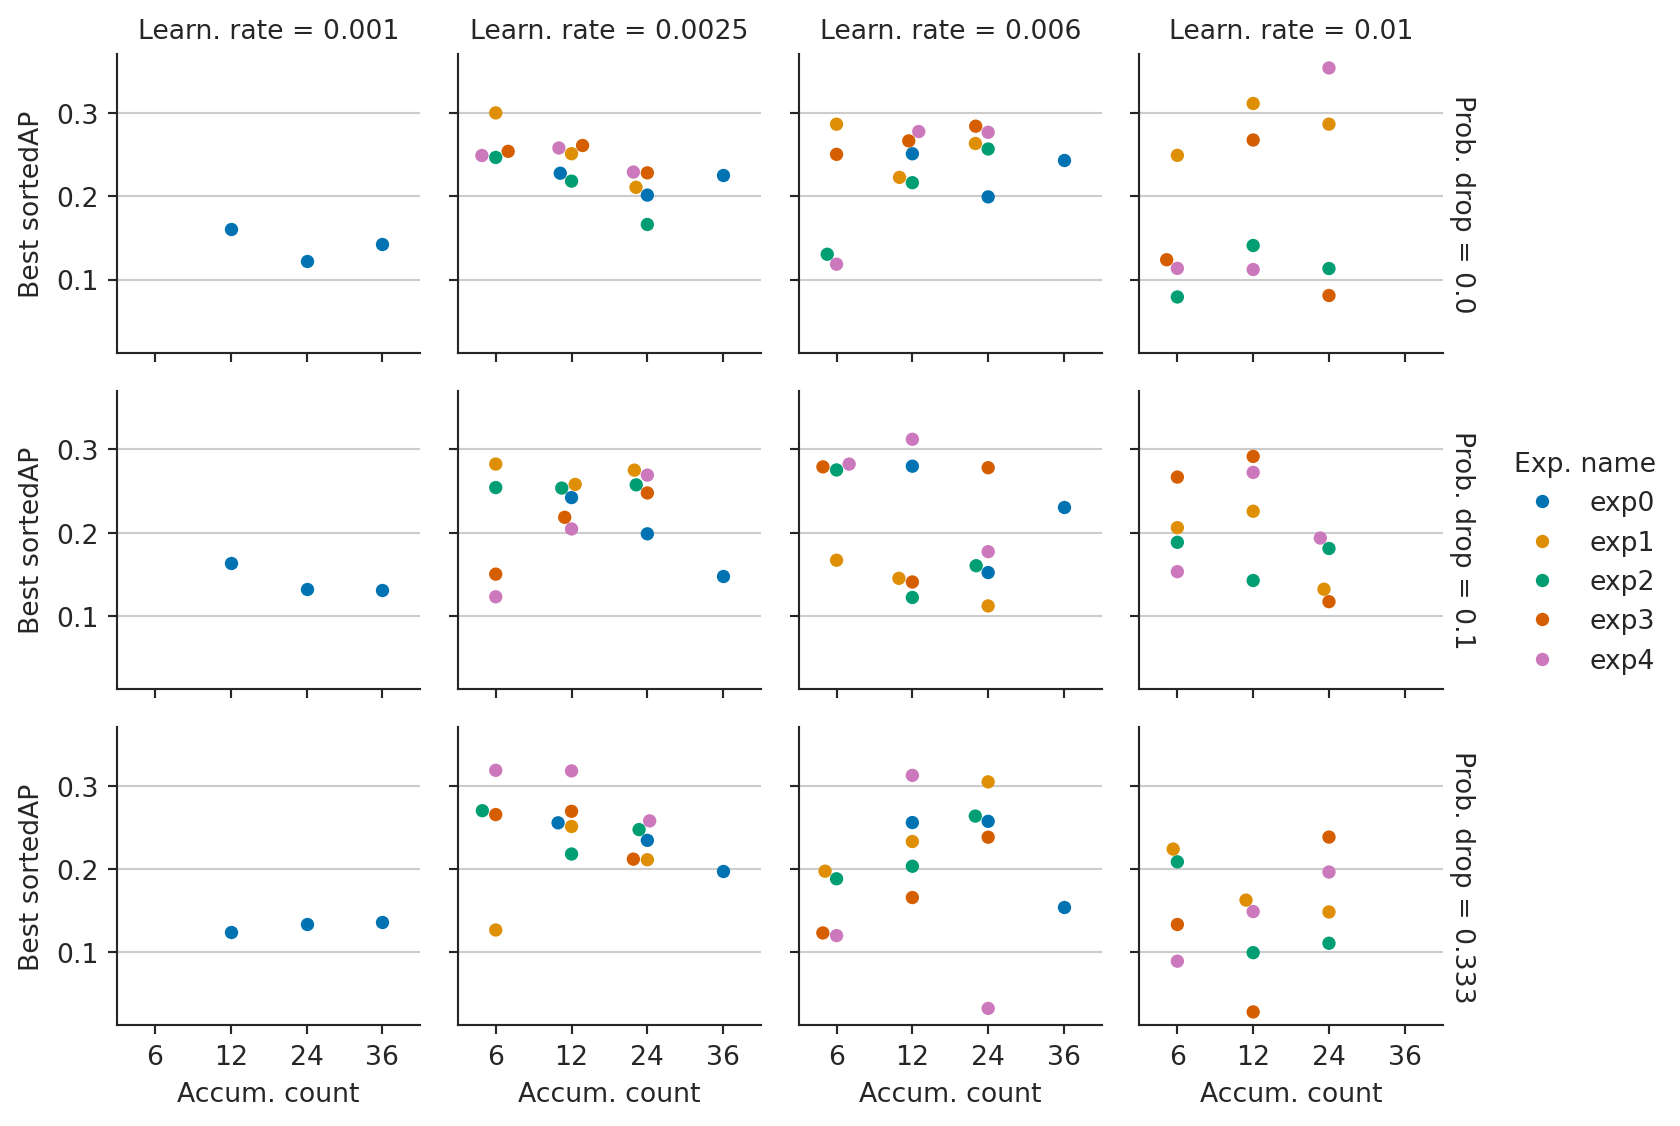

In [1]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("data/training_params_experiment_all.csv")
df = df[df["Data used for evaluation"] == "RGB, CIR and CHM"]
df["Prob. drop"] = df["proba_drop_chm"]
df.rename(columns = {
    "accumulate": "Accum. count",
    "Data used for evaluation": "Evaluation data",
    "lr": "Learn. rate",
    "repartition_name": "Exp. name"
  },
  inplace=True)
sns.set_style("ticks", {"axes.grid": True})
sns.catplot(
    data=df,
    kind="swarm",
    x="Accum. count",
    y="Best sortedAP",
    hue="Exp. name",
    hue_order=["exp0", "exp1", "exp2", "exp3", "exp4"],
    col="Learn. rate",
    row="Prob. drop",
    margin_titles=True,
    height=2,
    aspect=1,
    palette="colorblind"
)

In the next plot \[@fig-training-parameters-data\], we can see more results for the same experiments. Here, the results are colored according to the data that we use to evaluate the model. In blue, we see the value of sortedAP when we evaluate the model with the CHM layers data and dummy zero arrays as RGB/CIR data. These dummy arrays are also those that are used as input when one of the channel is dropped during training, when we have a drop probability larger than 0. Some interesting patterns appear in some of the cells in this plot. Firstly, it looks like randomly dropping one of the two inputs with the same probability has a much larger influence over the results using RGB/CIR than CHM. While CHM gives better results than RGB/CIR when always training using everything, RGB/CIR seems to perform better alone when also trained alone, even outperforming the combination of both inputs in certain cases.

/home/alexandre/anaconda3/envs/tree-segment/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning:

6.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/alexandre/anaconda3/envs/tree-segment/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning:

20.0% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.

/home/alexandre/anaconda3/envs/tree-segment/lib/python3.11/site-packages/seaborn/categorical.py:3399: UserWarning:

16.7% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.


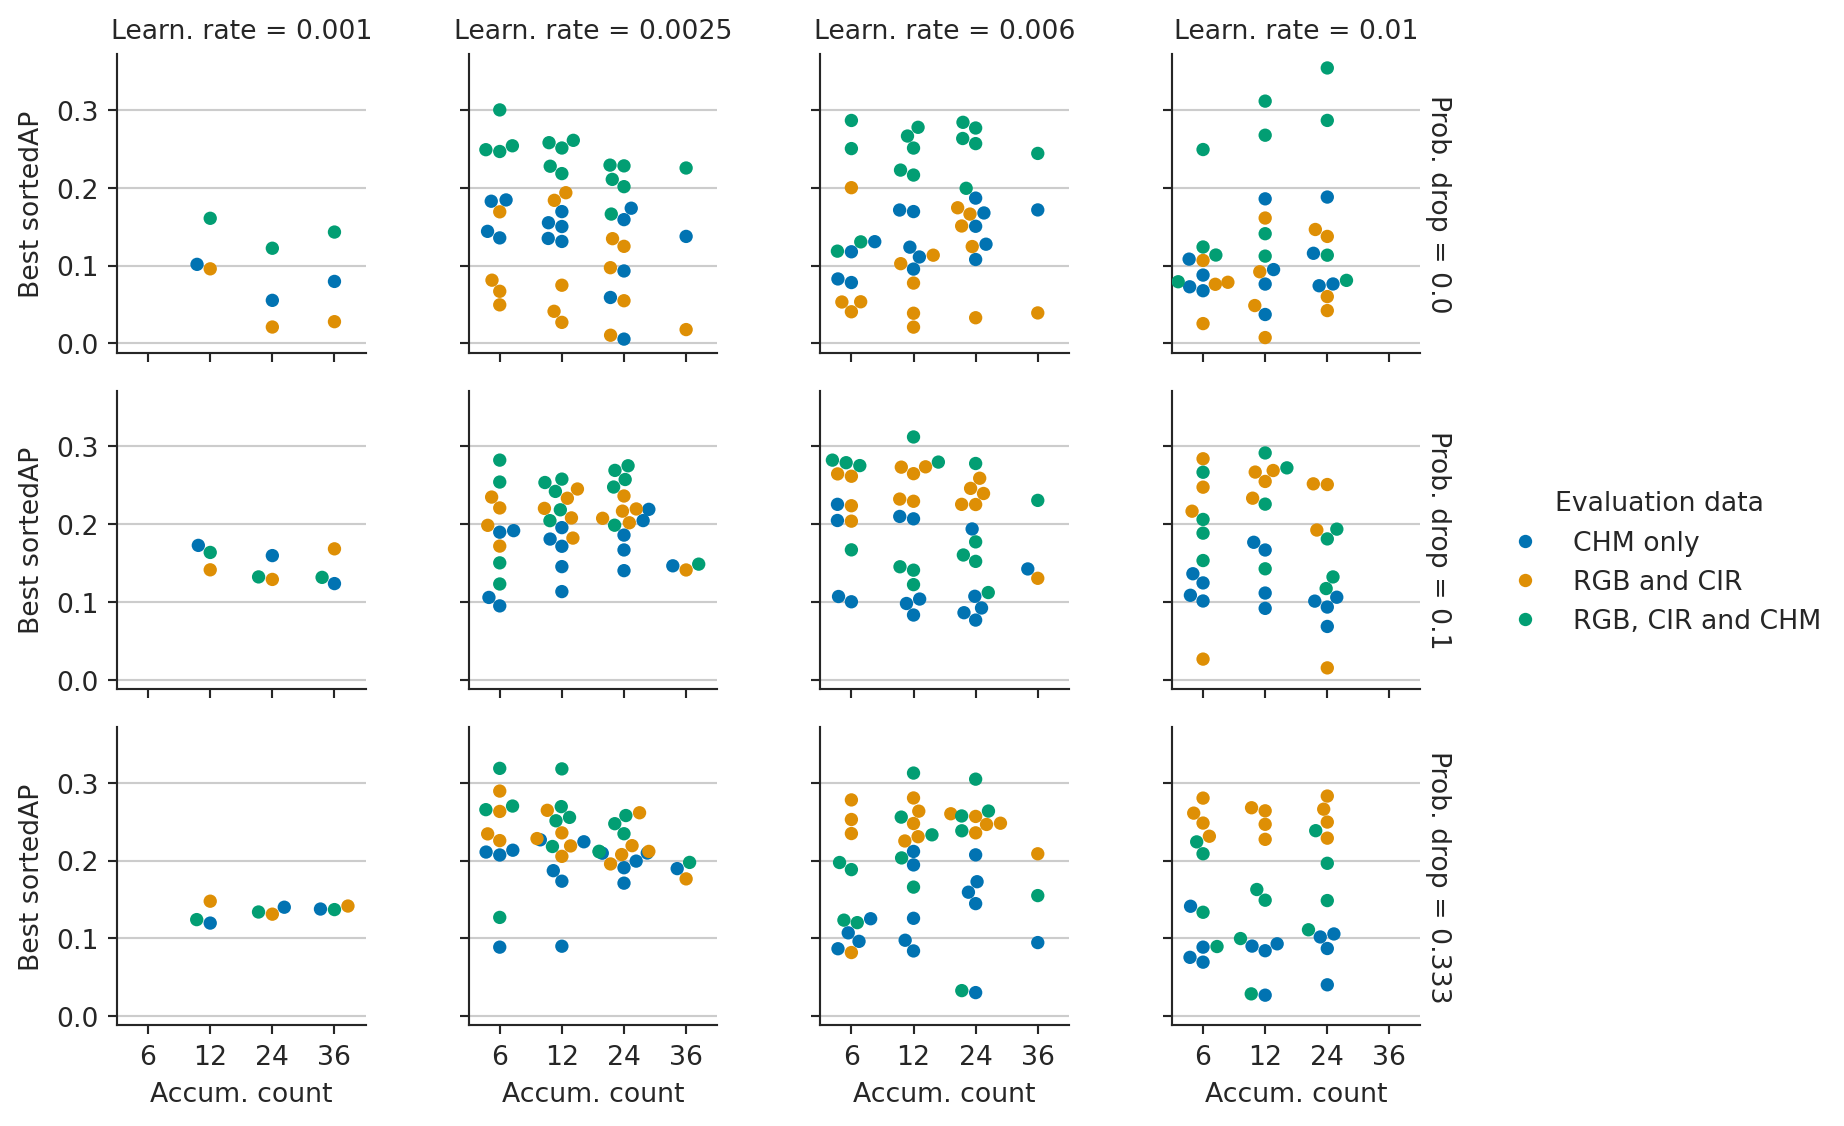

In [2]:
import pandas as pd
import seaborn as sns

df = pd.read_csv("data/training_params_experiment_all.csv")
df.sort_values(
    by=["proba_drop_chm", "Data used for evaluation"],
    inplace=True,
)
df["Prob. drop"] = df["proba_drop_chm"]
df.rename(columns = {
    "accumulate": "Accum. count",
    "Data used for evaluation": "Evaluation data",
    "lr": "Learn. rate"
  },
  inplace=True)
sns.set_style("ticks", {"axes.grid": True})
sns.catplot(
    data=df,
    kind="swarm",
    x="Accum. count",
    y="Best sortedAP",
    hue="Evaluation data",
    col="Learn. rate",
    row="Prob. drop",
    margin_titles=True,
    height=2,
    aspect=1,
    palette="colorblind"
)

From the results of this experiment, I decided to pick the following parameters for the next experiments:

-   Initial learning rate: 0.004
-   Drop probability: 0
-   Accumulation count: 10

### Data used

### CHM layers

### Hard trees

## Discussion

### Dataset

-   DeepForest: A Python package for RGB deep learning tree crown delineation \[@DeepForest\]: uses only RGB data to detect trees, but uses LiDAR to create millions of annotations of moderate quality to pre-train the model, before using around 10,000 hand-annotations to finalize and specialize the training on a certain area.

### Combination of data types

## Conclusion

Blablabla